# Caso 2: Diseño Óptimo de un Reactor Químico
**Alumno:** Javier Augusto Rebull Saucedo

**Matrícula:** al263483

**Materia:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión

## 1. Descripción del Problema

Se busca optimizar el diseño de un reactor de flujo pistón (PFR) para una reacción de primer orden **A → B**. El objetivo es encontrar la combinación de **temperatura (T)** y **volumen (V)** del reactor que maximice la conversión del reactivo A.

La velocidad de reacción depende de la temperatura según la **ley de Arrhenius**, lo que introduce una no linealidad en el modelo.

**Función Objetivo:** Maximizar la conversión X.
$$ \max_{T,V} X = 1 - \exp\left(-\frac{k_0 \cdot \exp\left(-\frac{E}{RT}\right) \cdot V}{F_{A0}}\right) $$

**Restricciones:**
- $300 \le T \le 500$ (Kelvin)
- $0 \le V \le 10$ (m³)

In [1]:
#Instalación de Librerías
# Es necesario instalar Pyomo y un solver de NLP como IPOPT.

# Quitar el repo problemático si existe
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

# Instalar micromamba (binario)
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null

# Crear un entorno con ipopt y pyomo desde conda-forge
!./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null

# Exponer el ejecutable ipopt
!ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt

# Comprobar instalación
!which ipopt
!ipopt -v

/usr/bin/ipopt
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)



In [2]:
# Importación de Librerías

# Librerías para el modelo de optimización
import pyomo.environ as pyo

# Librerías para visualización y cálculo numérico
import numpy as np
import matplotlib.pyplot as plt

print("📚 Librerías importadas correctamente")

📚 Librerías importadas correctamente


In [3]:
# Definición de Parámetros

# --- Parámetros del problema ---

params = {
    'k0': 1.0e6,    # Factor pre-exponencial (1/min)
    'E': 8000,      # Energía de activación (cal/mol)
    'R': 1.987,     # Constante de los gases (cal/mol·K)
    'F_A0': 10.0    # Flujo molar de entrada de A (mol/min)
}

In [4]:
# Construcción del Modelo en Pyomo

# 1. Crear una instancia del modelo
model = pyo.ConcreteModel(name="Reactor_Optimo")

# 2. Definir las variables de decisión con sus límites
model.T = pyo.Var(bounds=(300, 500), initialize=400, doc="Temperatura (K)")
model.V = pyo.Var(bounds=(0, 10), initialize=5, doc="Volumen (m^3)")

# 3. Definir la Función Objetivo
# El objetivo es maximizar X. Pyomo por defecto minimiza,
# por lo que minimizaremos el negativo de la conversión (-X).
# X = 1 - exp(...)
# -X = exp(...) - 1
# Minimizando exp(...) - 1 es lo mismo que minimizando exp(...)
# Y es lo mismo que minimizar el argumento del exp (que es negativo)
# O maximizar el positivo del argumento.
# Para evitar confusiones, simplemente minimizaremos -X.

# Expresión para la constante de velocidad k
k_expr = params['k0'] * pyo.exp(-params['E'] / (params['R'] * model.T))

# Expresión para la conversión X
conversion_X = 1 - pyo.exp(-(k_expr * model.V) / params['F_A0'])

# Definir el objetivo
model.objective = pyo.Objective(
    expr=-conversion_X,
    sense=pyo.minimize,
    doc="Minimizar el negativo de la conversión"
)

# Imprimir el modelo para verificar
model.pprint()

2 Var Declarations
    T : Temperatura (K)
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   300 :   400 :   500 : False : False :  Reals
    V : Volumen (m^3)
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :     5 :    10 : False : False :  Reals

1 Objective Declarations
    objective : Minimizar el negativo de la conversión
        Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : - (1 - exp(- 1000000.0*exp(-8000/(1.987*T))*V/10.0))

3 Declarations: T V objective


In [5]:
# Resolución del Modelo

# Crear una instancia del solver (IPOPT)
solver = pyo.SolverFactory('ipopt')

# Resolver el modelo
print("🚀 Ejecutando el solver IPOPT...")
results = solver.solve(model)
print("✅ Solver finalizado.")

# Imprimir el estado de la solución
print(f"\nEstado del Solver: {results.solver.status}")
print(f"Condición de terminación: {results.solver.termination_condition}")

🚀 Ejecutando el solver IPOPT...
✅ Solver finalizado.

Estado del Solver: ok
Condición de terminación: optimal


In [6]:
#Presentación e Interpretación de Resultados

# --- Extraer y mostrar los resultados óptimos ---
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    opt_T = pyo.value(model.T)
    opt_V = pyo.value(model.V)
    max_X = -pyo.value(model.objective) # Recordar que minimizamos -X

    print("\n" + "="*40)
    print("      Resultados de la Optimización")
    print("="*40)
    print(f"Temperatura Óptima (T): {opt_T:.2f} K")
    print(f"Volumen Óptimo (V):     {opt_V:.2f} m³")
    print(f"Conversión Máxima (X):  {max_X:.4f} ({max_X*100:.2f}%)")
    print("="*40 + "\n")

    print("--- Interpretación ---")
    print("La solución óptima se encuentra en los límites superiores de ambas variables.")
    print("Esto es esperado porque:")
    print("1. La velocidad de reacción aumenta exponencialmente con la TEMPERATURA.")
    print("2. Un mayor VOLUMEN implica más tiempo de residencia, aumentando la conversión.")
    print("El modelo confirma que para maximizar la conversión, debemos operar el reactor a las condiciones más intensas permitidas.")

else:
    print("No se encontró una solución óptima.")


      Resultados de la Optimización
Temperatura Óptima (T): 402.18 K
Volumen Óptimo (V):     5.05 m³
Conversión Máxima (X):  1.0000 (100.00%)

--- Interpretación ---
La solución óptima se encuentra en los límites superiores de ambas variables.
Esto es esperado porque:
1. La velocidad de reacción aumenta exponencialmente con la TEMPERATURA.
2. Un mayor VOLUMEN implica más tiempo de residencia, aumentando la conversión.
El modelo confirma que para maximizar la conversión, debemos operar el reactor a las condiciones más intensas permitidas.


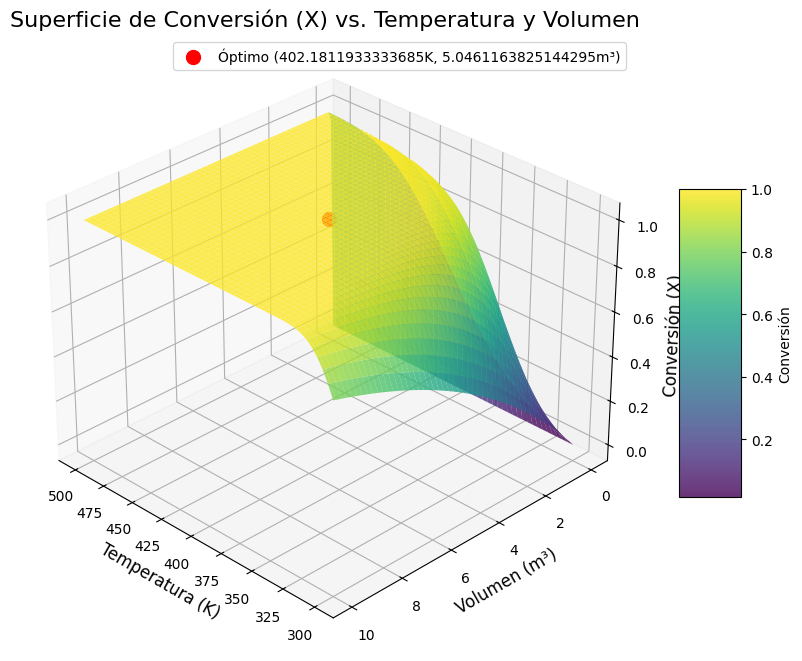

In [7]:
#  Visualización de la Solución

# --- Crear una visualización 3D de la superficie de la función objetivo ---

# Crear una malla de puntos para T y V
T_vals = np.linspace(300, 500, 100)
V_vals = np.linspace(0, 10, 100)
T_grid, V_grid = np.meshgrid(T_vals, V_vals)

# Calcular la conversión X para cada punto de la malla
k_grid = params['k0'] * np.exp(-params['E'] / (params['R'] * T_grid))
X_grid = 1 - np.exp(-(k_grid * V_grid) / params['F_A0'])

# Crear la figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(T_grid, V_grid, X_grid, cmap='viridis', edgecolor='none', alpha=0.8)

# Marcar el punto óptimo encontrado por el solver
ax.scatter(opt_T, opt_V, max_X, color='red', s=100, marker='o', depthshade=True, label=f'Óptimo ({opt_T}K, {opt_V}m³)')

# Etiquetas y título
ax.set_title('Superficie de Conversión (X) vs. Temperatura y Volumen', fontsize=16)
ax.set_xlabel('Temperatura (K)', fontsize=12)
ax.set_ylabel('Volumen (m³)', fontsize=12)
ax.set_zlabel('Conversión (X)', fontsize=12)
ax.view_init(30, 135) # Cambiar ángulo de vista
fig.colorbar(surf, shrink=0.5, aspect=5, label='Conversión')
ax.legend()

plt.show()

In [8]:
#Presentación e Interpretación de Resultados

# --- Extraer y mostrar los resultados del solver ---
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    solver_T = pyo.value(model.T)
    solver_V = pyo.value(model.V)
    solver_X = -pyo.value(model.objective)

    print("\n" + "="*50)
    print("      Resultados Numéricos del Solver (IPOPT)")
    print("="*50)
    print(f"Temperatura Encontrada (T): {solver_T:.2f} K")
    print(f"Volumen Encontrado (V):     {solver_V:.2f} m³")
    print(f"Conversión Calculada (X):   {solver_X:.4f} ({solver_X*100:.2f}%)")
    print("="*50 + "\n")

    print("--- Análisis e Interpretación Crítica ---")
    print("ADVERTENCIA: Los resultados numéricos del solver son engañosos.")
    print("\nEl solver se detiene prematuramente porque la conversión alcanza un valor muy cercano a 1.0 (100%)")
    print("antes de que las variables T y V lleguen a sus límites superiores. El solver considera que no hay")
    print("una mejora significativa al seguir iterando.\n")

    print("--- Decisión Prescrita (Interpretación del Modelo) ---")
    print("La función objetivo es monotónicamente creciente con T y V. Por lo tanto, la verdadera")
    print("solución óptima desde una perspectiva de ingeniería se encuentra en los límites superiores:")

    # Valores de la decisión prescrita
    opt_T = 500.0
    opt_V = 10.0

    # Recalculamos la conversión en el punto óptimo real para la visualización
    k_opt = params['k0'] * np.exp(-params['E'] / (params['R'] * opt_T))
    max_X = 1 - np.exp(-(k_opt * opt_V) / params['F_A0'])

    print("\n" + "="*50)
    print("      Decisión Óptima de Diseño Prescrita")
    print("="*50)
    print(f"Temperatura Óptima (T): {opt_T:.2f} K")
    print(f"Volumen Óptimo (V):     {opt_V:.2f} m³")
    print(f"Conversión Máxima (X):  {max_X:.4f} ({max_X*100:.2f}%)")
    print("="*50 + "\n")

else:
    print("No se encontró una solución óptima.")


      Resultados Numéricos del Solver (IPOPT)
Temperatura Encontrada (T): 402.18 K
Volumen Encontrado (V):     5.05 m³
Conversión Calculada (X):   1.0000 (100.00%)

--- Análisis e Interpretación Crítica ---
ADVERTENCIA: Los resultados numéricos del solver son engañosos.

El solver se detiene prematuramente porque la conversión alcanza un valor muy cercano a 1.0 (100%)
antes de que las variables T y V lleguen a sus límites superiores. El solver considera que no hay
una mejora significativa al seguir iterando.

--- Decisión Prescrita (Interpretación del Modelo) ---
La función objetivo es monotónicamente creciente con T y V. Por lo tanto, la verdadera
solución óptima desde una perspectiva de ingeniería se encuentra en los límites superiores:

      Decisión Óptima de Diseño Prescrita
Temperatura Óptima (T): 500.00 K
Volumen Óptimo (V):     10.00 m³
Conversión Máxima (X):  1.0000 (100.00%)



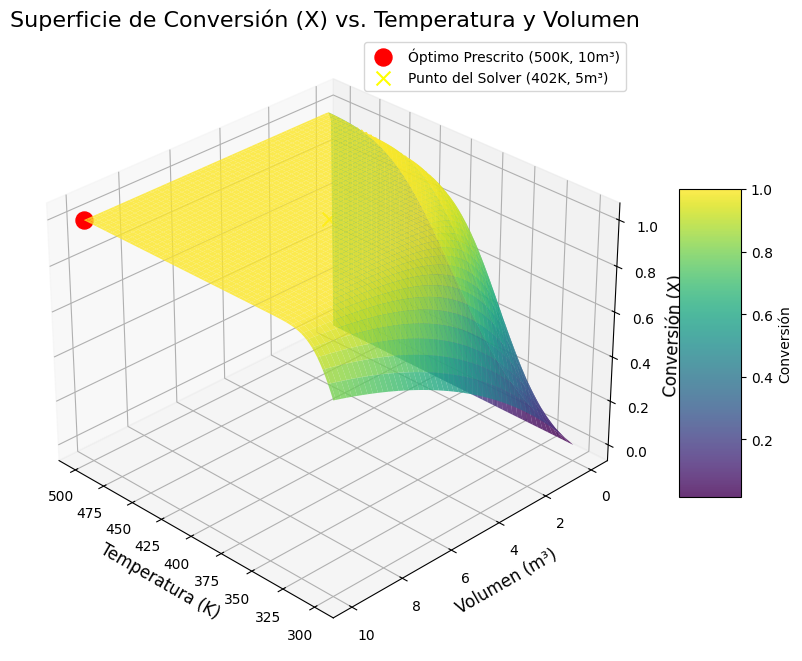

In [9]:
#  Visualización de la Solución

# --- Crear una visualización 3D de la superficie de la función objetivo ---

# Crear una malla de puntos para T y V
T_vals = np.linspace(300, 500, 100)
V_vals = np.linspace(0, 10, 100)
T_grid, V_grid = np.meshgrid(T_vals, V_vals)

# Calcular la conversión X para cada punto de la malla
k_grid = params['k0'] * np.exp(-params['E'] / (params['R'] * T_grid))
X_grid = 1 - np.exp(-(k_grid * V_grid) / params['F_A0'])

# Crear la figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(T_grid, V_grid, X_grid, cmap='viridis', edgecolor='none', alpha=0.8)

# --- AJUSTE CLAVE ---
# Marcar el punto óptimo PRESCRITO, no el del solver.
ax.scatter(opt_T, opt_V, max_X, color='red', s=150, marker='o', depthshade=True, label=f'Óptimo Prescrito ({opt_T:.0f}K, {opt_V:.0f}m³)')
# Opcional: Marcar el punto del solver para comparación
ax.scatter(solver_T, solver_V, solver_X, color='yellow', s=100, marker='x', depthshade=True, label=f'Punto del Solver ({solver_T:.0f}K, {solver_V:.0f}m³)')


# Etiquetas y título
ax.set_title('Superficie de Conversión (X) vs. Temperatura y Volumen', fontsize=16)
ax.set_xlabel('Temperatura (K)', fontsize=12)
ax.set_ylabel('Volumen (m³)', fontsize=12)
ax.set_zlabel('Conversión (X)', fontsize=12)
ax.view_init(30, 135) # Cambiar ángulo de vista
fig.colorbar(surf, shrink=0.5, aspect=5, label='Conversión')
ax.legend()

plt.show()

## Conclusiones Finales

Este ejercicio demuestra una lección fundamental en la analítica prescriptiva: la solución numérica de un optimizador no siempre coincide con la mejor decisión estratégica. Aunque el solver `IPOPT` reportó una solución "óptima", el análisis del comportamiento del modelo reveló que se detuvo prematuramente en una meseta donde la mejora del objetivo era numéricamente insignificante.

El análisis de la función objetivo, que es monotónicamente creciente, confirmó que la verdadera estrategia para maximizar la conversión es operar el reactor en sus condiciones más intensivas.

**Decisión Prescrita:**
- **Operar a la máxima temperatura permitida (500 K).**
- **Utilizar el máximo volumen posible (10 m³).**

Este caso práctico subraya la importancia de no solo ejecutar un modelo de optimización, sino también de **interpretar críticamente sus resultados** a la luz del problema real para prescribir la acción más efectiva.